## Librerias

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import hog, local_binary_pattern
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import random

## Google Drive

In [ ]:
import os
from datetime import date

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

current_dir = "/content/drive/My Drive/MiniProyecto2"

if not os.path.isdir(current_dir):
  os.makedirs(current_dir)

current_dir += '/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Descargar dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2


In [ ]:
print("Contents of the dataset directory:")
print(os.listdir(path))
image_path1 = path + '/HAM10000_images_part_1'
print(os.listdir(image_path1))
image_path2 = path + '/HAM10000_images_part_2'
print(os.listdir(image_path2))

Contents of the dataset directory:
['HAM10000_metadata.csv', 'ham10000_images_part_1', 'hmnist_8_8_RGB.csv', 'hmnist_28_28_RGB.csv', 'HAM10000_images_part_2', 'hmnist_8_8_L.csv', 'HAM10000_images_part_1', 'hmnist_28_28_L.csv', 'ham10000_images_part_2']
['ISIC_0025151.jpg', 'ISIC_0027407.jpg', 'ISIC_0026369.jpg', 'ISIC_0028189.jpg', 'ISIC_0027261.jpg', 'ISIC_0026538.jpg', 'ISIC_0026969.jpg', 'ISIC_0029236.jpg', 'ISIC_0025896.jpg', 'ISIC_0027659.jpg', 'ISIC_0027675.jpg', 'ISIC_0028461.jpg', 'ISIC_0029192.jpg', 'ISIC_0025132.jpg', 'ISIC_0029098.jpg', 'ISIC_0024888.jpg', 'ISIC_0028823.jpg', 'ISIC_0027845.jpg', 'ISIC_0026765.jpg', 'ISIC_0025376.jpg', 'ISIC_0026077.jpg', 'ISIC_0025439.jpg', 'ISIC_0027252.jpg', 'ISIC_0028007.jpg', 'ISIC_0026967.jpg', 'ISIC_0025707.jpg', 'ISIC_0026557.jpg', 'ISIC_0026258.jpg', 'ISIC_0025452.jpg', 'ISIC_0028281.jpg', 'ISIC_0024743.jpg', 'ISIC_0028612.jpg', 'ISIC_0028395.jpg', 'ISIC_0026034.jpg', 'ISIC_0024901.jpg', 'ISIC_0027954.jpg', 'ISIC_0028222.jpg', 'ISIC_

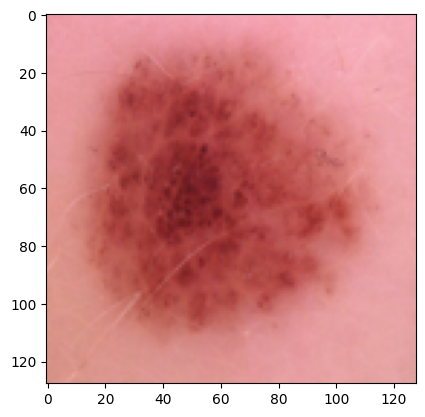

In [ ]:
from PIL import Image

image_file = os.path.join(path+"/HAM10000_images_part_1", "ISIC_0025151.jpg")
image = Image.open(image_file)

image_resized = image.resize((128, 128))

plt.imshow(image_resized)  # Display the image

In [ ]:
image_file = os.path.join(path, "hmnist_8_8_RGB.csv")
data_8_8_label = pd.read_csv(image_file)['label']
data_8_8_label

,label
0,2
1,2
2,2
3,2
4,2
...,...
10010,0
10011,0
10012,0
10013,0


In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image

def image_to_csv(image_folder1, image_folder2, output_csv, labels):
    """
    Converts images in a folder to a CSV file with flattened RGB data.

    Parameters:
        image_folder (str): Path to the folder containing images.
        output_csv (str): Path to save the resulting CSV file.
    """
    data = []
    for i, image_name in enumerate(os.listdir(image_folder1)):
        image_path = os.path.join(image_folder1, image_name)
        try:
            # Open and resize the image to 8x8
            image = Image.open(image_path).resize((64, 64))

            # Convert the image to an array (8x8x3)
            image_array = np.array(image)

            # Flatten the array to 1D (8*8*3 = 192 for RGB)
            flattened = image_array.flatten()

            # Optionally add a label column
            #if label_mapping and image_name in label_mapping:
            #    flattened = np.append(flattened, label_mapping[image_name])
            flattened = np.append(flattened, labels[i])

            # Append the flattened image data
            data.append(flattened)
        except Exception as e:
            print(f"Error processing image {image_name}: {e}")

    for i, image_name in enumerate(os.listdir(image_folder2)):
        image_path = os.path.join(image_folder2, image_name)
        try:
            # Open and resize the image to 8x8
            image = Image.open(image_path).resize((64, 64))

            # Convert the image to an array (8x8x3)
            image_array = np.array(image)

            # Flatten the array to 1D (8*8*3 = 192 for RGB)
            flattened = image_array.flatten()

            # Optionally add a label column
            #if label_mapping and image_name in label_mapping:
            #    flattened = np.append(flattened, label_mapping[image_name])
            flattened = np.append(flattened, labels[i+len(os.listdir(image_folder1))])

            # Append the flattened image data
            data.append(flattened)
        except Exception as e:
            print(f"Error processing image {image_name}: {e}")

    # Create column names
    num_pixels = 64 * 64 * 3  # For RGB
    columns = [f"pixel_{i}" for i in range(num_pixels)]
    columns.append("label")

    # Convert to DataFrame
    df = pd.DataFrame(data, columns=columns)

    # Save to CSV
    df.to_csv(output_csv, index=False)
    print(f"CSV file saved to {output_csv}")

# Example Usage
output_csv = "hmnist_64_64.csv"       # Output CSV file
#label_mapping = {"image1.jpg": 0, "image2.jpg": 1}  # Optional labels
labels = data_8_8_label

image_to_csv(image_path1, image_path2, output_csv, labels)

NameError: name 'data_8_8_label' is not defined

## Extracción de características

In [ ]:
# Parámetros de HOG
hog_params = {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2), 'block_norm': 'L2-Hys'}

# Parámetros de LBP
radius = 3
n_points = 8 * radius
method = 'uniform'

# Función para leer el CSV y convertir los datos en imágenes
def load_images_from_csv(csv_path):
    # Cargar el CSV
    data = pd.read_csv(csv_path)

    # Separar las etiquetas (si están presentes)
    if 'label' in data.columns:
        labels = data['label']
        data = data.drop('label', axis=1)
    else:
        labels = None

    # Convertir los valores de los píxeles en una matriz numpy y redimensionar a imágenes 28x28 RGB
    images = data.values.reshape(-1, 64, 64, 3).astype(np.uint8)  # Cambiar tipo a uint8 para compatibilidad
    return images, labels

In [ ]:
# Extraer características HOG y LBP
def extract_features(images):
    hog_images = []
    hog_features = []
    lbp_features = []
    for img in images:
        # Asegurarse de que la imagen esté en formato uint8
        img = img.astype(np.uint8)
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Convertir a escala de grises

        # Extraer HOG
        hog_feat,hog_image = hog(gray_img, **hog_params,visualize=True)
        hog_features.append(hog_feat)
        hog_images.append(hog_image)

        # Extraer LBP
        lbp = local_binary_pattern(gray_img, n_points, radius, method)
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        lbp_hist = lbp_hist.astype("float")
        lbp_hist /= (lbp_hist.sum() + 1e-6)  # Normalizar
        lbp_features.append(lbp_hist)

    return np.array(hog_features), np.array(lbp_features) , np.array(hog_images)

In [ ]:
# Aplicar PCA para reducir la dimensionalidad
def apply_pca(features, n_components=50):
    pca = PCA(n_components=n_components)
    pca_features = pca.fit_transform(features)
    return pca_features

# Ruta al archivo CSV con las imágenes
csv_file_path = 'hmnist_64_64.csv'

# Cargar las imágenes del CSV
images, labels = load_images_from_csv(csv_file_path)

# Extraer características HOG y LBP
hog_features, lbp_features, hog_images = extract_features(images)

# Combinar HOG y LBP
combined_features = np.hstack((hog_features, lbp_features))
print(f"Dimensiones de las características combinadas: {combined_features.shape}")

# Aplicar PCA para reducir la dimensionalidad a 50 componentes
pca_features = apply_pca(combined_features, n_components=50)

# Guardar las características procesadas y las etiquetas (si están presentes)
np.save('features_pca.npy', pca_features)
if labels is not None:
    np.save('labels.npy', labels)

print("Extracción de características y PCA completados. Los resultados se han guardado en 'features_pca.npy' y 'labels.npy'.")

Dimensiones de las características combinadas: (10015, 1790)
Extracción de características y PCA completados. Los resultados se han guardado en 'features_pca.npy' y 'labels.npy'.


In [ ]:
hog_features.shape, hog_images.shape

((10015, 1764), (10015, 64, 64))

# HOG : Histogramas de Gradientes Orientados

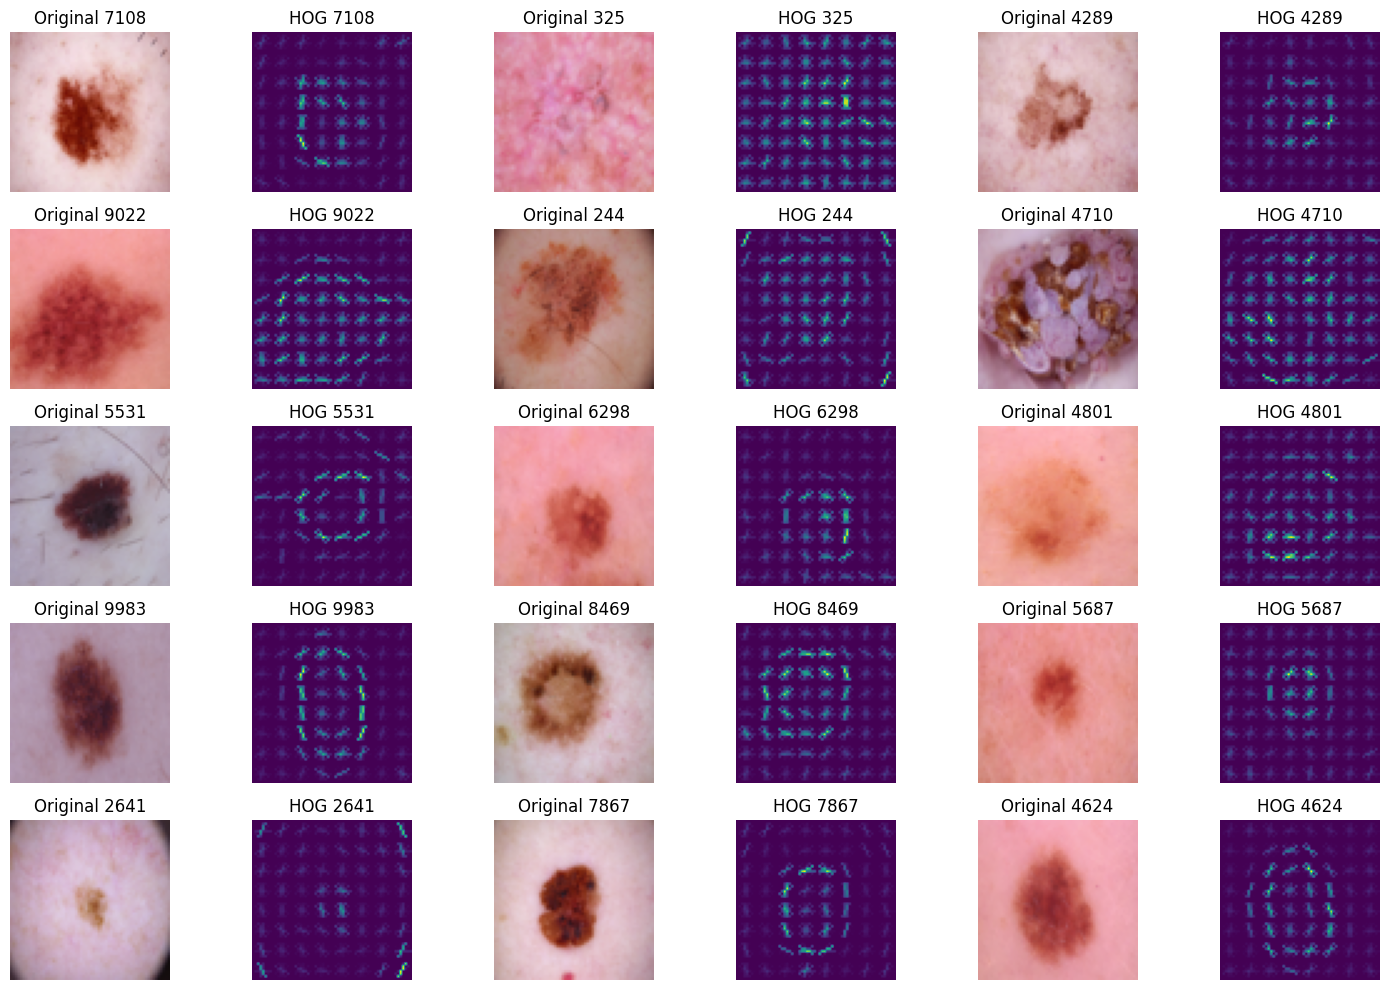

In [ ]:
# Seleccionar 15 índices aleatorios
random_indices = random.sample(range(len(images)), 15)

# Crear una figura con subgráficos
fig, axes = plt.subplots(5, 6, figsize=(15, 10))

for i, idx in enumerate(random_indices):
    row = i // 3
    col = (i % 3) * 2

    axes[row, col].imshow(images[idx])
    axes[row, col].set_title(f"Original {idx}")
    axes[row, col].axis('off')

    gray_img = cv2.cvtColor(images[idx], cv2.COLOR_RGB2GRAY)  # Convert image to grayscale
    _, hog_image = hog(gray_img, visualize=True, **hog_params)  # Get HOG features and visualization
    axes[row, col + 1].imshow(hog_image)
    axes[row, col + 1].set_title(f"HOG {idx}")
    axes[row, col + 1].axis('off')

plt.tight_layout()
plt.show()

# PCA: Análisis de Componentes Principales

In [ ]:
data_values = hog_features

In [ ]:
pca = PCA(n_components=data_values.shape[1], random_state=42)
pca.fit_transform(data_values)

array([[ 1.14350326e+00, -6.12667131e-01, -1.47453557e-01, ...,
         5.01701495e-03, -1.23538682e-03,  1.11642314e-02],
       [-2.15375283e-01,  5.75421674e-02,  7.02539212e-03, ...,
        -1.21203844e-03, -8.01425991e-05, -3.35119083e-04],
       [ 1.31911869e+00, -8.74988210e-01, -7.91667533e-02, ...,
        -3.71943145e-03, -4.46510795e-03,  5.64330603e-03],
       ...,
       [ 9.96268798e-01,  4.19199984e-01, -3.83784831e-01, ...,
        -4.61242591e-04, -6.83269863e-03,  5.58116265e-03],
       [-5.88567450e-01,  2.47351518e-01,  4.37320443e-01, ...,
        -4.81105834e-03, -7.36248169e-04,  2.16567196e-03],
       [-1.28212304e+00, -5.13041741e-02,  1.43679308e-01, ...,
         5.59529401e-03,  6.77573206e-03,  6.01355962e-03]])

El número de componentes para el 90% de la varianza explicada es 390.


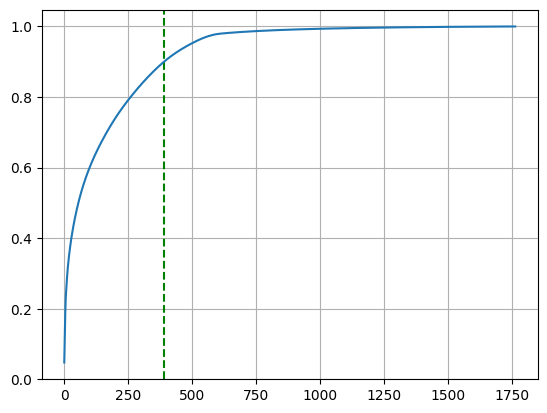

In [ ]:
y = np.cumsum(pca.explained_variance_ratio_)
componente_90 = np.where(y > 0.90)[0][0]
print(f'El número de componentes para el 90% de la varianza explicada es {componente_90}.')

plt.axvline(componente_90, linestyle='--', color='green')
plt.plot(y)
plt.grid()

In [ ]:
data_values = hog_features
data_values.shape

(10015, 1764)

In [ ]:
pca = PCA(componente_90, random_state=42)
pca_features = pca.fit_transform(data_values)
df = pd.DataFrame(pca_features)
df.to_csv('pca_hmnist_64_64.csv')
df.to_csv(current_dir + 'pca_hmnist_64_64.csv')

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,...,380,381,382,383,384,385,386,387,388,389
0,1.143503,-0.612667,-0.147454,-1.382734,-0.424350,-0.051854,-0.577394,0.343480,0.387222,0.134998,...,-0.031738,-0.015781,0.148693,0.061231,-0.006814,0.157960,-0.030566,-0.049203,-0.001316,0.157425
1,-0.215375,0.057542,0.007025,-0.805379,-0.128460,0.127249,-0.127332,0.340922,-0.150189,-0.109645,...,0.127007,-0.058317,-0.121843,-0.128028,0.005364,-0.082583,0.016546,0.070004,0.029770,-0.015967
2,1.319119,-0.874988,-0.079167,-1.518655,-1.007489,0.034265,0.186091,0.710441,-0.016555,0.367521,...,-0.008871,-0.155590,-0.008547,-0.062374,0.009522,-0.024477,-0.119662,0.142190,0.034407,-0.031321
3,0.205716,0.918700,1.441504,0.069445,-0.924662,0.119411,0.132809,-0.021020,0.065816,-0.453116,...,-0.095813,-0.001744,-0.020621,-0.061293,-0.066958,-0.060941,-0.041883,-0.046135,0.026276,-0.052369
4,-1.051119,-0.649724,-0.415783,-0.713941,1.472102,0.091528,-0.293481,0.588870,-0.175864,0.248228,...,-0.077336,-0.032500,-0.009948,-0.128175,0.065529,0.105943,-0.087123,-0.115980,-0.120547,-0.041208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,0.033963,-0.348922,0.715388,0.000541,-0.375346,-0.011370,-0.079223,-0.230987,0.361387,0.059447,...,-0.042131,0.010381,-0.083554,-0.122027,-0.153236,0.034212,-0.081727,0.029174,-0.040235,0.156477
10011,0.573996,1.084461,0.815211,0.816983,-1.007224,-1.025063,-0.014584,-0.094245,0.149505,-0.444155,...,-0.059587,-0.021869,0.020113,0.082593,0.154165,-0.206268,0.041340,-0.060409,-0.015442,0.048099
10012,0.996269,0.419200,-0.383785,0.544161,1.644768,-0.231920,0.215033,-0.384192,0.488265,-0.619263,...,0.100796,-0.159222,0.017940,-0.011338,0.044815,0.084742,0.021014,0.098234,-0.093811,0.171818
10013,-0.588567,0.247352,0.437320,0.343700,0.000047,0.255948,0.249183,-0.383399,-0.064976,-0.068239,...,0.043337,0.051158,0.043931,0.081329,-0.147563,-0.105467,0.034783,0.085280,0.033886,0.020452


# Clasificadores

### Instalaciones

In [ ]:
!pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 567.7/567.7 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 836.6/836.6 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.2/133.2 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.9/196.9 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 78.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.7/722.7 kB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 916.0/916.0 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.6/242.6 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## SVM: Máquina de soporte vectorial

### Imágenes originales

In [ ]:
from cuml.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

# Ruta al archivo CSV con las imágenes
csv_file_path = 'hmnist_64_64.csv'

# Cargar las imágenes del CSV
images, labels = load_images_from_csv(current_dir + csv_file_path)
flat_size = 64*64*3
images_flattened = images.reshape((images.shape[0], flat_size))

images_flattened = images_flattened.astype('float32')
labels = labels.astype('int32')
print(images_flattened.dtype)  # Tipo de datos de X
print(labels.dtype)  # Tipo de datos de y

X_train, X_test, y_train, y_test = train_test_split(images_flattened, labels, test_size=0.3, random_state=42)

#param_grid = {
#    'C': [0.1, 1, 10, 100],
#    'gamma': ['scale', 'auto', 0.01, 0.001],
#    'kernel': ['rbf']
#}

#grid = GridSearchCV(SVC(class_weight='balanced'), param_grid, cv=3)
#grid.fit(X_train, y_train)
svc = SVC(kernel='rbf', C=1, gamma='scale', class_weight='balanced')
svc.fit(X_train, y_train)

#y_pred = grid.best_estimator_.predict(X_test)
y_pred = svc.predict(X_test)

NameError: name 'pca_features' is not defined

In [ ]:
np.unique(y_pred, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6], dtype=int32),
 array([247, 431, 626, 379, 781, 131, 410]))

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.06      0.16      0.09        96
           1       0.05      0.14      0.07       143
           2       0.13      0.23      0.16       350
           3       0.02      0.18      0.03        39
           4       0.73      0.28      0.41      1997
           5       0.00      0.00      0.00        33
           6       0.14      0.16      0.15       347

    accuracy                           0.25      3005
   macro avg       0.16      0.16      0.13      3005
weighted avg       0.52      0.25      0.32      3005



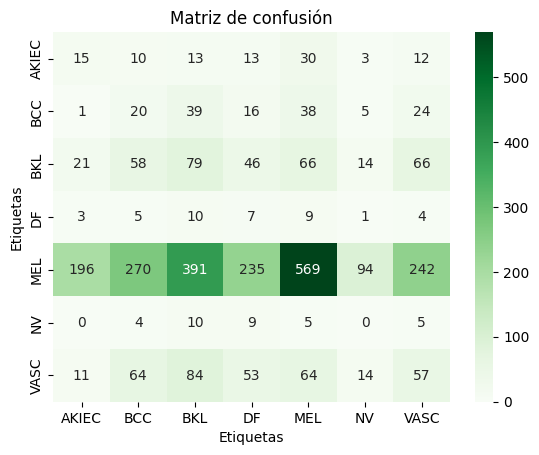

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

etiquetas = ['NV', 'MEL', 'BKL', 'BCC', 'AKIEC', 'VASC', 'DF']

C = confusion_matrix(y_test, y_pred)
sns.heatmap(C, annot=True, fmt='d', cmap='Greens', xticklabels=np.unique(etiquetas), yticklabels=np.unique(etiquetas))
plt.title('Matriz de confusión')
plt.xlabel('Etiquetas')
plt.ylabel('Etiquetas');

### Features con PCA

In [ ]:
# Ruta al archivo CSV con las imágenes
csv_file_path = 'pca_hmnist_64_64.csv'

# Cargar las imágenes del CSV
pca_features = pd.read_csv(current_dir + csv_file_path)

X_train, X_test, y_train, y_test = train_test_split(pca_features, labels, test_size=0.3, random_state=42)

#param_grid = {
#    'C': [0.1, 1, 10, 100],
#    'gamma': ['scale', 'auto', 0.01, 0.001],
#    'kernel': ['rbf']
#}

#grid = GridSearchCV(SVC(class_weight='balanced'), param_grid, cv=3)
#grid.fit(X_train, y_train)
svc = SVC(kernel='rbf', C=1, gamma='scale', class_weight='balanced')
svc.fit(X_train, y_train)

#y_pred = grid.best_estimator_.predict(X_test)
y_pred = svc.predict(X_test)

[W] [02:52:08.016555] Warning: could not fill working set, found only 743 elements
[W] [02:52:08.018663] Warning: could not fill working set, found only 857 elements
[W] [02:52:08.022007] Warning: could not fill working set, found only 1003 elements
[W] [02:52:08.086516] Warning: could not fill working set, found only 883 elements
[W] [02:52:08.087541] Warning: could not fill working set, found only 771 elements
[W] [02:52:08.088804] Warning: could not fill working set, found only 867 elements
[W] [02:52:08.138170] Warning: could not fill working set, found only 883 elements
[W] [02:52:08.139799] Warning: could not fill working set, found only 852 elements
[W] [02:52:08.184794] Warning: could not fill working set, found only 883 elements
[W] [02:52:08.186269] Warning: could not fill working set, found only 833 elements
[W] [02:52:08.187684] Warning: could not fill working set, found only 925 elements
[W] [02:52:08.188308] Warning: could not fill working set, found only 1023 elements
[W

In [ ]:
np.unique(y_pred, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6], dtype=int32),
 array([ 169,  206,  329,   89, 1835,  102,  275]))

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.57      1.00      0.72        96
           1       0.55      0.79      0.65       143
           2       1.00      0.94      0.97       350
           3       0.44      1.00      0.61        39
           4       1.00      0.92      0.96      1997
           5       0.32      1.00      0.49        33
           6       1.00      0.79      0.88       347

    accuracy                           0.90      3005
   macro avg       0.70      0.92      0.75      3005
weighted avg       0.95      0.90      0.92      3005



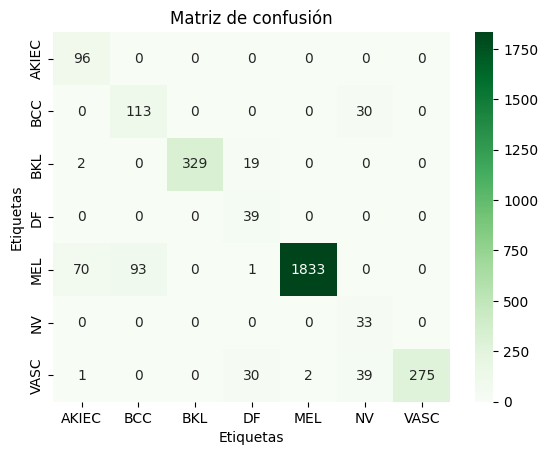

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

etiquetas = ['NV', 'MEL', 'BKL', 'BCC', 'AKIEC', 'VASC', 'DF']

C = confusion_matrix(y_test, y_pred)
sns.heatmap(C, annot=True, fmt='d', cmap='Greens', xticklabels=np.unique(etiquetas), yticklabels=np.unique(etiquetas))
plt.title('Matriz de confusión')
plt.xlabel('Etiquetas')
plt.ylabel('Etiquetas');

El SVM con PCA muestra un rendimiento significativamente mejorado, alcanzando un accuracy del 90% y métricas equilibradas (precision, recall, F1-score), gracias a la reducción de dimensionalidad que simplificó la representación de los datos y eliminó ruido innecesario.

**Comparativa:**
En comparación con el SVM sin PCA (con imágenes originales), donde las métricas fueron mucho más bajas debido a la alta dimensionalidad y falta de preprocesamiento, el uso de PCA permitió al modelo manejar mejor la complejidad, resultando en fronteras de decisión más precisas y un mejor desempeño global.



## Regresión logística con Softmax

### Imágenes originales

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

# Ruta al archivo CSV con las imágenes
csv_file_path = 'hmnist_64_64.csv'

# Cargar las imágenes del CSV
images, labels = load_images_from_csv(current_dir + csv_file_path)
flat_size = 64*64*3
images_flattened = images.reshape((images.shape[0], flat_size))

images_flattened = images_flattened.astype('float32')  / 255.0
labels = labels.astype('int32').values
print(images_flattened.dtype)  # Tipo de datos de X
print(labels.dtype)  # Tipo de datos de y

print('labels')
print(labels)

X_train, X_test, y_train, y_test = train_test_split(images_flattened, labels, test_size=0.3, random_state=42)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(flat_size,)),  # Tamaño de entrada
    tf.keras.layers.Dense(7, activation='softmax')  # 7 clases (salida multiclase)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print(class_weight_dict)

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, class_weight=class_weight_dict)

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

float32
int32
labels
[2 2 2 ... 0 0 6]
{0: 4.3351886209029065, 1: 2.699268386599923, 2: 1.337020789624261, 3: 13.176691729323307, 4: 0.2127078528947688, 5: 9.187418086500655, 6: 1.3073480044759418}
Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.1424 - loss: 5.2649 - val_accuracy: 0.1056 - val_loss: 2.4593
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1372 - loss: 3.8117 - val_accuracy: 0.1854 - val_loss: 1.7346
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1210 - loss: 3.6600 - val_accuracy: 0.0100 - val_loss: 5.9618
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1122 - loss: 3.5847 - val_accuracy: 0.0185 - val_loss: 4.2275
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1482 - loss: 3.5630 - val_accuracy: 0.1056 - val_loss: 2.5453
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1331 - loss: 3.9028 - val_accuracy: 0.2175 - val_loss: 1.9784
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━

In [ ]:
np.unique(y_pred_classes, return_counts=True)

(array([0, 1, 4, 5, 6]), array([ 764, 1412,  823,    1,    5]))

In [ ]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.04      0.29      0.07        96
           1       0.05      0.53      0.10       143
           2       0.00      0.00      0.00       350
           3       0.00      0.00      0.00        39
           4       0.68      0.28      0.40      1997
           5       0.00      0.00      0.00        33
           6       0.00      0.00      0.00       347

    accuracy                           0.22      3005
   macro avg       0.11      0.16      0.08      3005
weighted avg       0.46      0.22      0.27      3005



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


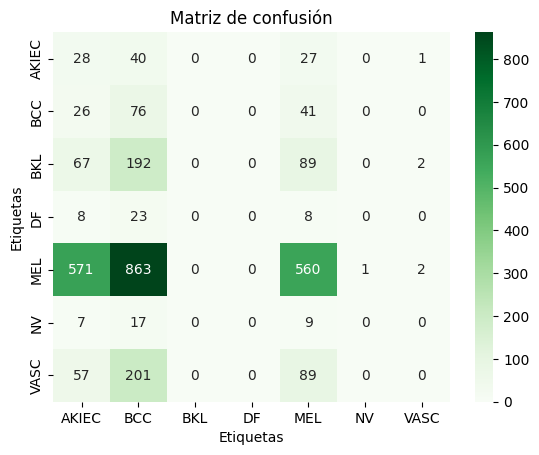

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

etiquetas = ['NV', 'MEL', 'BKL', 'BCC', 'AKIEC', 'VASC', 'DF']

C = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(C, annot=True, fmt='d', cmap='Greens', xticklabels=np.unique(etiquetas), yticklabels=np.unique(etiquetas))
plt.title('Matriz de confusión')
plt.xlabel('Etiquetas')
plt.ylabel('Etiquetas');

### Features con PCA

In [ ]:
# Ruta al archivo CSV con las imágenes
csv_file_path = 'pca_hmnist_64_64.csv'

# Cargar las imágenes del CSV
pca_features = pd.read_csv(current_dir + csv_file_path)
print('Shape:', pca_features.shape)

X_train, X_test, y_train, y_test = train_test_split(pca_features, labels, test_size=0.3, random_state=42)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(pca_features.shape[1],)),  # Tamaño de entrada
    tf.keras.layers.Dense(7, activation='softmax')  # 7 clases (salida multiclase)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print(class_weight_dict)

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, class_weight=class_weight_dict)

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

Shape: (10015, 391)
{0: 4.3351886209029065, 1: 2.699268386599923, 2: 1.337020789624261, 3: 13.176691729323307, 4: 0.2127078528947688, 5: 9.187418086500655, 6: 1.3073480044759418}
Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0769 - loss: 292.1278 - val_accuracy: 0.6298 - val_loss: 1.2399
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2876 - loss: 2.2422 - val_accuracy: 0.0407 - val_loss: 3.2276
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2395 - loss: 2.0882 - val_accuracy: 0.1170 - val_loss: 2.4692
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3089 - loss: 2.1653 - val_accuracy: 0.6919 - val_loss: 1.0315
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2899 - loss: 2.2351 - val_accuracy: 0.0642 - val_loss: 3.6825
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2848 - loss: 2.0068 - val_accuracy: 0.7019 - val_loss: 1.0708
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

In [ ]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.05      0.99      0.10        96
           1       0.14      0.25      0.18       143
           2       0.89      0.62      0.73       350
           3       0.00      0.00      0.00        39
           4       0.72      0.08      0.14      1997
           5       0.03      0.39      0.06        33
           6       0.22      0.04      0.07       347

    accuracy                           0.18      3005
   macro avg       0.29      0.34      0.18      3005
weighted avg       0.61      0.18      0.20      3005



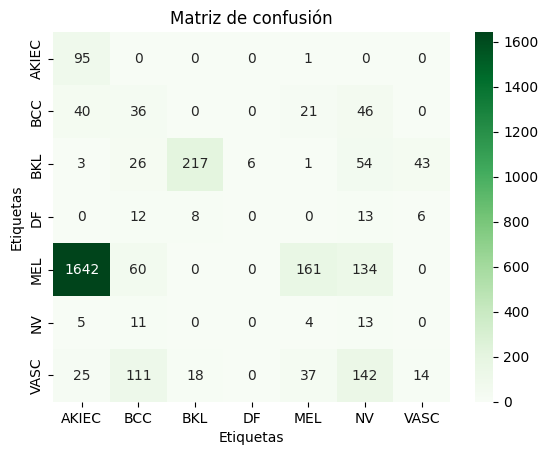

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

etiquetas = ['NV', 'MEL', 'BKL', 'BCC', 'AKIEC', 'VASC', 'DF']

C = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(C, annot=True, fmt='d', cmap='Greens', xticklabels=np.unique(etiquetas), yticklabels=np.unique(etiquetas))
plt.title('Matriz de confusión')
plt.xlabel('Etiquetas')
plt.ylabel('Etiquetas');

El uso de PCA mejoró el desempeño en clases como 2, pero redujo el desempeño global debido a la dificultad de la Regresión Logística para manejar datos transformados con pérdida de características críticas. Esto significa que, para datasets grandes y complejos como este, la Regresión Logística no es el modelo ideal.

## Regresión logística con OvR

### Imágenes originales

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Ruta al archivo CSV con las imágenes
csv_file_path = 'hmnist_64_64.csv'

# Cargar las imágenes del CSV
images, labels = load_images_from_csv(current_dir + csv_file_path)
flat_size = 64 * 64 * 3
images_flattened = images.reshape((images.shape[0], flat_size)).astype('float32') / 255.0
labels = labels.astype('int32')

# Verificar los datos
print("Tipo de datos de imágenes:", images_flattened.dtype)
print("Tipo de datos de etiquetas:", labels.dtype)
print("Clases únicas:", np.unique(labels))

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(images_flattened, labels, test_size=0.3, random_state=42)

# Crear y entrenar modelos OvR
unique_classes = np.unique(y_train)
models = {}

for cls in unique_classes:
    print(f"Entrenando modelo para la clase {cls}...")

    # Crear etiquetas binarizadas (1 para la clase actual, 0 para las demás)
    y_train_binary = (y_train == cls).astype('float32').values

    # Calcular los pesos para la clase actual
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.array([0, 1]),
        y=y_train_binary
    )
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

    # Definir el modelo binario para la clase
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(flat_size,)),  # Tamaño de entrada
        tf.keras.layers.Dense(1, activation='sigmoid')  # Salida binaria
    ])

    # Compilar el modelo
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo
    model.fit(
        X_train,
        y_train_binary,
        epochs=10,
        batch_size=32,
        validation_split=0.2,
        class_weight=class_weight_dict,
        verbose=1
    )

    models[cls] = model

class_scores = []
for cls in unique_classes:
    print(f"Prediciendo para la clase {cls}...")
    class_scores.append(models[cls].predict(X_test, verbose=0).flatten())

class_scores = np.array(class_scores)

y_pred = np.argmax(class_scores, axis=0)

# Evaluar el modelo
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))


Tipo de datos de imágenes: float32
Tipo de datos de etiquetas: int32
Clases únicas: [0 1 2 3 4 5 6]
Entrenando modelo para la clase 0...
Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5177 - loss: 1.0746 - val_accuracy: 0.0635 - val_loss: 1.5342
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4648 - loss: 1.2032 - val_accuracy: 0.0250 - val_loss: 5.1752
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4825 - loss: 1.0899 - val_accuracy: 0.9515 - val_loss: 0.3152
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4948 - loss: 1.3297 - val_accuracy: 0.9700 - val_loss: 0.1787
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5630 - loss: 1.1634 - val_accuracy: 0.0328 - val_loss: 1.6925
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4906 - loss: 1.1549 - val_accuracy: 0.9750 - val_loss: 0.1254
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5667 - loss: 1.0548 - val_acc

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
np.unique(y_pred, return_counts=True)

(array([0, 2, 3, 4, 5, 6]), array([  74,    1,    6,   61, 2862,    1]))

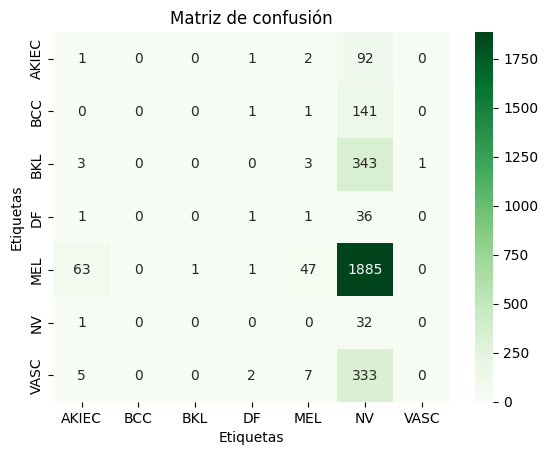

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

etiquetas = ['NV', 'MEL', 'BKL', 'BCC', 'AKIEC', 'VASC', 'DF']

C = confusion_matrix(y_test, y_pred)
sns.heatmap(C, annot=True, fmt='d', cmap='Greens', xticklabels=np.unique(etiquetas), yticklabels=np.unique(etiquetas))
plt.title('Matriz de confusión')
plt.xlabel('Etiquetas')
plt.ylabel('Etiquetas');

### Features con PCA

In [ ]:
# Ruta al archivo CSV con las imágenes
csv_file_path = 'pca_hmnist_64_64.csv'

# Cargar las imágenes del CSV
pca_features = pd.read_csv(current_dir + csv_file_path)
print('Shape:', pca_features.shape)

X_train, X_test, y_train, y_test = train_test_split(pca_features, labels, test_size=0.3, random_state=42)

# Crear y entrenar modelos OvR
unique_classes = np.unique(y_train)
models = {}

for cls in unique_classes:
    print(f"Entrenando modelo para la clase {cls}...")

    # Crear etiquetas binarizadas (1 para la clase actual, 0 para las demás)
    y_train_binary = (y_train == cls).astype('float32').values

    # Calcular los pesos para la clase actual
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.array([0, 1]),
        y=y_train_binary
    )
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

    # Definir el modelo binario para la clase
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(pca_features.shape[1],)),  # Tamaño de entrada
        tf.keras.layers.Dense(1, activation='sigmoid')  # Salida binaria
    ])

    # Compilar el modelo
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo
    model.fit(
        X_train,
        y_train_binary,
        epochs=10,
        batch_size=32,
        validation_split=0.2,
        class_weight=class_weight_dict,
        verbose=1
    )

    models[cls] = model

class_scores = []
for cls in unique_classes:
    print(f"Prediciendo para la clase {cls}...")
    class_scores.append(models[cls].predict(X_test, verbose=0).flatten())

class_scores = np.array(class_scores)

y_pred = np.argmax(class_scores, axis=0)

# Evaluar el modelo
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))

Shape: (10015, 391)
Entrenando modelo para la clase 0...
Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7510 - loss: 121.6172 - val_accuracy: 0.1284 - val_loss: 0.9134
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2721 - loss: 1.0543 - val_accuracy: 0.1476 - val_loss: 0.9100
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3692 - loss: 0.9240 - val_accuracy: 0.9629 - val_loss: 0.3787
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4219 - loss: 1.0392 - val_accuracy: 0.2332 - val_loss: 0.8591
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3794 - loss: 1.2220 - val_accuracy: 0.0506 - val_loss: 4.4110
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4398 - loss: 1.0347 - val_accuracy: 0.9508 - val_loss: 0.4887
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4207 - loss: 0.9137 - val_accuracy: 0.9715 - val_loss: 0.2930
Epoch 8/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2m

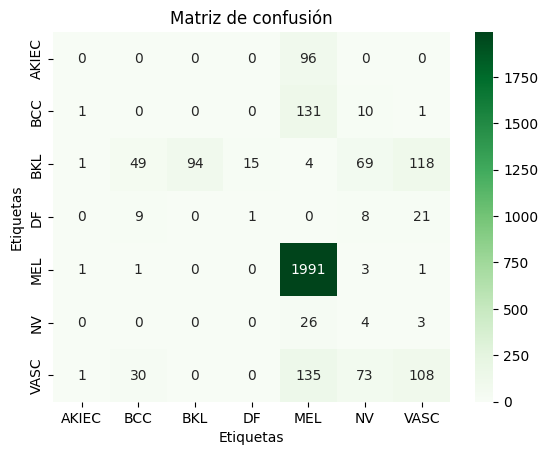

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

etiquetas = ['NV', 'MEL', 'BKL', 'BCC', 'AKIEC', 'VASC', 'DF']

C = confusion_matrix(y_test, y_pred)
sns.heatmap(C, annot=True, fmt='d', cmap='Greens', xticklabels=np.unique(etiquetas), yticklabels=np.unique(etiquetas))
plt.title('Matriz de confusión')
plt.xlabel('Etiquetas')
plt.ylabel('Etiquetas');



*   Accuracy extremadamente bajo (3%): El modelo no logra distinguir adecuadamente las clases, reflejado en valores muy bajos de precisión, recall y F1-score en la mayoría de las clases.
*   El enfoque OVR mejora considerablemente con PCA, pasando de un modelo que no clasifica nada a uno funcional con un accuracy del 73%. Esto evidencia que la reducción de dimensionalidad no solo simplifica el problema, sino que permite al modelo enfocar su capacidad en los patrones más relevantes. Sin embargo, se requiere balancear las clases.



## Conclusiones



*   El dataset era muy grande y contenía muchas imágenes, por lo que se necesitaba una GPU mediante las librerías CuML y TensorFlow, además de un hardware robusto. Asimismo, se intentó usar GridSearch para encontrar los hiperparámetros óptimos, pero el hardware nuevamente fue un limitante, por lo que se decidió no utilizarlo. Esto generó una disminución en la accuracy o recall del modelo de clasificación, lo cual se reflejó aún más al trabajar con las imágenes originales.
*  El clasificador que tuvo mejor comportamiento fue el de SVM con PCA; el SVM con PCA supera a la Regresión Logística Softmax y OVR debido a su capacidad para manejar fronteras no lineales, reducir ruido con PCA y evitar el sobreajuste en escenarios complejos o con alta dimensionalidad.

